In [1]:
!pip install -U sentence-transformers
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=329dda95e7738ce4d582e020ddb44214301f1563f35ce90f6e9568aa010c84cf
  Stored in directory: /root/.cache/pip/wheels/83/71/2b/40d17d21937fed496fb99145227eca8f20b4891240ff60c86f
Successfully built sentence-transformers


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [3]:
import pandas as pd
import os
import pickle
import gensim
from gensim.models import Word2Vec
import numpy as np
import re
from sklearn.model_selection import train_test_split
import tensorflow
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.models import Sequential
from keras.layers import Input,Dense, Dropout, Embedding, LSTM, Bidirectional, TimeDistributed, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import to_categorical, pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_recall_fscore_support as score
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [4]:
def readFile(path):
    with open(path, 'r', encoding="utf-8") as f:
        text = f.read()
    return text


In [5]:
def removePunct(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r" +", " ", text)
    return text


def preProcess(data):
    temp = []
    for d in data:
        text = removePunct(d)
        temp.append(text)
    return temp


In [6]:
def getData(text):
    x = []
    y = []
    data = text.split("\n")
    for d in data:
        try:
            x_, y_ = d.split("\t")
            x.append(x_)
            y.append(y_)
        except:
            pass
    x = preProcess(x)
    y = preProcess(y)
    return [x, y]

def removeLongSentence(data_all, n):
    x_fin = []
    for idx,ele in enumerate(data_all):
        ele_split = ele.split()
        if len(ele_split) < n and len(ele_split) > 1:
            x_fin.append(ele)            
    return x_fin

In [7]:
train_data = readFile("/kaggle/input/nlp-project/train.txt")
test_data = readFile("/kaggle/input/nlp-project/dev.txt")
# ngram = 4

In [8]:
_, x_train = getData(train_data)
_, x_test = getData(test_data)


In [9]:
x_train, x_val = train_test_split(x_train, test_size=0.1, random_state=42)

In [10]:
max_sent_len_limit = 100
x_train_red = removeLongSentence(x_train,max_sent_len_limit)
x_val_red = removeLongSentence(x_val,max_sent_len_limit)
x_test_red = removeLongSentence(x_test,max_sent_len_limit)

In [11]:
len(x_train_red)

6731

In [12]:
len(x_test_red)

895

In [13]:
def trainTokenizeData(data_all, max_sent_len_limit):
    data_all = removeLongSentence(data_all, max_sent_len_limit)
    x_tokenizer = Tokenizer(oov_token='<UNK>', num_words=4451)
    x_tokenizer.fit_on_texts(data_all)
    x_encoded = x_tokenizer.texts_to_sequences(data_all)
    return x_encoded, x_tokenizer


def testTokenizeData(data_all, x_tokenizer, max_sent_len_limit):
    data_all = removeLongSentence(data_all, max_sent_len_limit)
    x_encoded = x_tokenizer.texts_to_sequences(data_all)
    return x_encoded

In [14]:
x_train_seq, train_tokenizer = trainTokenizeData(x_train_red, max_sent_len_limit)
x_dev_seq = testTokenizeData(x_val_red, train_tokenizer, max_sent_len_limit)
x_test_seq = testTokenizeData(x_test_red, train_tokenizer, max_sent_len_limit)

In [15]:
def getMaxLen(x_train, x_dev, x_test):
    max1 = max([len(x) for x in x_train])
    max2 = max([len(x) for x in x_dev])
    max3 = max([len(x) for x in x_test])
    return max(max1, max2, max3)


In [16]:
def splitPadSequences(X_tokenized, max_sequence_len, total_words=4451):
    input_sequences = []
    for ele in X_tokenized:
#         for i in range(len(ele)-ngram+1):
#             n_gram_sequence = ele[i:i+ngram]
#             input_sequences.append(n_gram_sequence)
        for i in range(1, len(ele)):
            n_gram_sequence = ele[:i+1]
            input_sequences.append(n_gram_sequence)

    
    predictors = []
    label = []
    for ele in input_sequences:
        predictors.append(ele[:-1])
        label.append(ele[-1])                 
#     input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
#     predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = np.array(label)
    label = to_categorical(label, num_classes=total_words)

    return predictors, label

In [17]:
def convertSequenceToText(x_seq_data_text, tokenizer):
    return tokenizer.sequences_to_texts(x_seq_data_text)

def encodeSentence(x_text_data_encode,model_encode):
    embeddings = model_encode.encode(x_text_data_encode)
    return embeddings

def encodeSequences(x_seq_data_text,tokenizer,model):
    x_text_data_encode = convertSequenceToText(x_seq_data_text,tokenizer)
    encoded_x = encodeSentence(x_text_data_encode,model)
    return encoded_x

In [18]:
max_len = getMaxLen(x_train_seq, x_dev_seq, x_test_seq)
x_train_sp, y_train_sp = splitPadSequences(x_train_seq, max_len)
x_val_sp, y_val_sp = splitPadSequences(x_dev_seq, max_len)
x_test_sp, y_test_sp = splitPadSequences(x_test_seq, max_len)

In [19]:
len(x_test_sp)

10499

In [20]:
model_encoder = SentenceTransformer('aditeyabaral/sentencetransformer-bert-hinglish-small')

In [21]:
x_train_en = encodeSequences(x_train_sp,train_tokenizer,model_encoder)
x_val_en = encodeSequences(x_val_sp,train_tokenizer,model_encoder)
x_test_en = encodeSequences(x_test_sp,train_tokenizer,model_encoder)

Batches:   0%|          | 0/2347 [00:00<?, ?it/s]

Batches:   0%|          | 0/262 [00:00<?, ?it/s]

Batches:   0%|          | 0/329 [00:00<?, ?it/s]

In [22]:
x_train_en.shape

(75075, 768)

In [23]:
x_test_en.shape

(10499, 768)

In [24]:
y_train_sp.shape

(75075, 4451)

In [25]:
def createModel(embedding_dim, total_words, dropout = 0.05):
    model = Sequential()
    model.add(Dense(1024, input_shape=(embedding_dim,), activation='sigmoid'))
    model.add(Dense(2048, activation='sigmoid'))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop', metrics=['acc'])
    model.build()
    model.summary()    
    return model


In [26]:
def trainModel(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=128):
    # filepath = "model.h5"
    # checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
    #                              save_best_only=True, mode='min')
    early = EarlyStopping(monitor="val_loss",
                          patience=5, verbose=1)
    callbacks_list = [early]
    history = model.fit(x_train, y_train, epochs=epochs,
                        batch_size = batch_size, verbose=2, callbacks=callbacks_list, validation_data=(x_val, y_val))
    return history


In [27]:
def generate_text(seed_text, next_words, max_sequence_len, tokenizer, model,en_model):
    fin_text = ""
    for i in range(next_words):
        input_embeddings = en_model.encode(seed_text)
        input_embeddings = input_embeddings.reshape(1,768)
        predicted = model.predict(input_embeddings,verbose = 0)
        predicted = np.argmax(predicted[0])
        output_word = ""
        for index, word in tokenizer.index_word.items():
            if index == predicted:
                output_word = word
                break
        fin_text += str(output_word) + " "
        seed_text += str(output_word) + " "
    return fin_text

def list_to_string(x_list_elements):
    fin_str = ""
    for ele in x_list_elements:
        fin_str += ele + " "
    return fin_str

def get_rouge_score(model,en_model,last_n_words,x_sentences,tokenizer,max_sequence_len):
    rouge_scores = []
    rouge = Rouge()
    for idx,ele in enumerate(x_sentences):
        ele_fin = ele.split()[:-last_n_words]
        ele_short_sent = list_to_string(ele_fin)
        ele_true_token = ele.split()[-last_n_words:]
        ele_true_sent = list_to_string(ele_true_token)
        pred_sent = generate_text(ele_short_sent,last_n_words,max_sequence_len,tokenizer,model,en_model)
        scores = rouge.get_scores(pred_sent, ele_true_sent, avg=True)
        rouge_scores.append(scores['rouge-l']['f'])
    return rouge_scores

def get_all_rouge_scores(model,en_model,x_sentences,tokenizer,max_sequence_len):
    last_n_words = [3,4,5]
    all_rouge_scores = []
    for ele in last_n_words:
        r_scores = get_rouge_score(model,en_model,ele,x_test_red,train_tokenizer,max_len)
        all_rouge_scores.append(np.mean(r_scores))
        print("Rouge Scores done for last ", ele , " words")
    return all_rouge_scores, last_n_words

def plot_rouge_scores(all_rouge_scores_mean,last_n_words):
    plt.xlabel("Predicted Words")
    plt.ylabel("Rouge Scores")
    plt.title("Predicted Words vs Rouge Scores")
    # plot lines
    last_n_words = [format(x, 'd') for x in last_n_words]
    plt.bar(last_n_words, all_rouge_scores_mean,color ='b',width = 0.4)
    plt.show()

In [28]:
def calculate_preplexity(dataset_line,y_pred, Y):
    val = 0
    for idx in range(len(dataset_line)-1):
        Y_idx = np.argmax(Y[idx])
        p_val = y_pred[idx][Y_idx]
        val += np.log2(p_val)
    val = -1*(val/(len(dataset_line)-1))
    return 2**val


def get_all_preplexity_scores(dataset_lines, y_pred, Y):
    preplexity_scores = []
    counter = 0
    next_counter = 0
    for idx, ele in enumerate(dataset_lines):
        next_counter += (len(ele) - 1)
        preplexity_scores.append(calculate_preplexity(
            ele, y_pred[counter:next_counter], Y[counter:next_counter]))
        counter = next_counter
    return preplexity_scores, np.mean(preplexity_scores)

def evaluate_model(model,en_model, datalines, X_test, Y_test, model_name):
    y_pred_test = model.predict(X_test)
    preplexity_scores_test, mean_score_test = get_all_preplexity_scores(
        datalines, y_pred_test, Y_test)
    y_pred_fl=np.argmax(y_pred_test, axis=1)
    y_test_fl=np.argmax(Y_test, axis=1)
    print("\n",model_name," Mean Perplexity Score is: ",mean_score_test)
    print("\nAccuracy Score:", accuracy_score(y_test_fl, y_pred_fl))
    print("\nPrecision Score:", precision_score(y_test_fl, y_pred_fl, average='macro'))
    print("\nRecall Score:", recall_score(y_test_fl, y_pred_fl, average='macro'))
    print("\nF1 Score:", f1_score(y_test_fl, y_pred_fl, average='macro'),"\n\n")
    
#     all_rouge_scores, last_n_words = get_all_rouge_scores(model,en_model,x_test_red,train_tokenizer,max_len)
#     plot_rouge_scores(all_rouge_scores, last_n_words)
    
#     print("\nClassification Report:\n", classification_report(y_test_fl, y_pred_fl))

In [29]:
model_generic = createModel(768, 4451)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              787456    
                                                                 
 dense_1 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_2 (Dense)             (None, 4451)              9120099   
                                                                 
Total params: 12,006,755
Trainable params: 12,006,755
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_hist = trainModel(model_generic, x_train_en, y_train_sp,
                        x_val_en, y_val_sp, batch_size=512)


Epoch 1/10
147/147 - 5s - loss: 6.5292 - acc: 0.0515 - val_loss: 6.2079 - val_acc: 0.0966 - 5s/epoch - 36ms/step
Epoch 2/10
147/147 - 2s - loss: 6.4279 - acc: 0.0522 - val_loss: 6.1865 - val_acc: 0.0966 - 2s/epoch - 17ms/step
Epoch 3/10
147/147 - 3s - loss: 6.4109 - acc: 0.0532 - val_loss: 6.2012 - val_acc: 0.0535 - 3s/epoch - 18ms/step
Epoch 4/10
147/147 - 3s - loss: 6.4044 - acc: 0.0531 - val_loss: 6.1956 - val_acc: 0.0966 - 3s/epoch - 19ms/step
Epoch 5/10
147/147 - 3s - loss: 6.3993 - acc: 0.0536 - val_loss: 6.2142 - val_acc: 0.0535 - 3s/epoch - 17ms/step
Epoch 6/10
147/147 - 3s - loss: 6.3959 - acc: 0.0538 - val_loss: 6.1980 - val_acc: 0.0966 - 3s/epoch - 18ms/step
Epoch 7/10
147/147 - 3s - loss: 6.3937 - acc: 0.0531 - val_loss: 6.1965 - val_acc: 0.0535 - 3s/epoch - 18ms/step
Epoch 7: early stopping


In [31]:
model_generic.save("transformer_language_model.h5")

In [32]:
# model_generic = load_model('/kaggle/input/nlp-chodu/transformer_language_model.h5')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


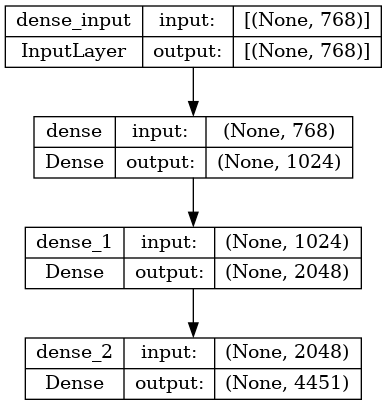

In [33]:
plot_model(model_generic, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
evaluate_model(model_generic,model_encoder, x_test_seq, x_test_en,y_test_sp,"Generic Ngram Model")

329/329 [==============================] - 1s 2ms/step

 Generic Ngram Model  Mean Perplexity Score is:  739.8090466329787

Accuracy Score: 0.04829031336317745

Precision Score: 3.1357346339725614e-05

Recall Score: 0.0006493506493506494

F1 Score: 5.9825691299432904e-05 




/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
input_Sentence = 'hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke'
full_sentence = 'hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye isko dekh loonga'
output_sentence = generate_text(input_Sentence,4,max_len,train_tokenizer,model_generic,model_encoder)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
print("\nInput Sentence: \n", input_Sentence)
print("\n\nFull Sentence: \n", full_sentence)
print("\n\nGenerated Sentence: \n",input_Sentence + " " + output_sentence)


Input Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke


Full Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke liye isko dekh loonga


Generated Sentence: 
 hello yar mein is movie ko nahi dekha hoon tho tho mein thode der ke hai hai hai hai 
